## Objective: Build and evaluate models

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df3 = pd.read_csv("../data_tables/supplier_cleaned_final.csv")

In [3]:
y = df3["cost"]
del df3["cost"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df3, y, test_size = 0.3)

In [5]:
# Change y to log (y+1)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [6]:
# Change qty to log(qty)
X_train["revised_qty"] = np.log(X_train["revised_qty"])
X_test["revised_qty"] = np.log(X_test["revised_qty"])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [7]:
del X_train["Unnamed: 0"]
del X_test["Unnamed: 0"]

In [8]:
def make_plot(y_true, y_pred, name):
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price")
    plt.title(name+" on test set")
    plt.scatter(np.exp(y_true)-1, np.exp(y_pred)-1)
    plt.plot((0,7), (0, 7), linestyle = "--", color = "blue")
    plt.show()

In [9]:
# Function for all base models
def base_model(model, name, X_train, X_test, y_train, y_test):
    "Base model characteristics"
    
    model.fit(X_train, y_train)
    
    # R2 Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name, "R2 training: ", r2_score(y_train, y_pred_train))
    print(name, "R2 test: ", r2_score(y_test, y_pred_test))
    
    # RMSLE
    sle = np.power((y_pred_test - y_test), 2)
    msle = np.mean(sle)
    rmsle = np.sqrt(msle)
    print(name, "RMSLE test: ", rmsle)
    
    # CV scores
    scores = cross_val_score(model, X_train, y_train, cv = 5)
    print(name, "CV Score: ", scores.mean(), "+/-", scores.std())
    
    # Plot
#    make_plot(y_test, y_pred_test, name)

In [10]:
# Function for all grid search models
def gs_model(model, name, X_train, X_test, y_train, y_test):
    
    # Execute GridSearch
    model.fit(X_train, y_train)
    print("Best score: ", model.best_score_)
    print("Best params: ", model.best_params_)
    
    # Predicted values
    y_pred_test = model.predict(X_test)
    print(name, "R2 test: ", r2_score(y_test, y_pred_test))
    sle = np.power((y_pred_test - y_test), 2)
    msle = np.mean(sle)
    rmsle = np.sqrt(msle)
    print(name, "RMSLE test: ", rmsle)
    
#    make_plot(y_test, y_pred_test, name)

In [11]:
X_train_tree = X_train
X_test_tree = X_test

In [12]:
Xs_train_tree = scale(X_train_tree)
Xs_test_tree = scale(X_test_tree)

## Random Forest

In [30]:
# Base model
rfr = RandomForestRegressor(n_estimators = 150, min_samples_leaf = 1, min_samples_split = 3)
base_model(rfr, "Random Forest", Xs_train_tree, Xs_test_tree, y_train, y_test)

Random Forest R2 training:  0.984758918257
Random Forest R2 test:  0.769864748388
Random Forest RMSLE test:  0.394448272771
Random Forest CV Score:  0.896896211138 +/- 0.0046088708614


In [ ]:
# GridSearch model
params = {"min_samples_leaf": [1, 3, 5, 10],
          "n_estimators": [100, 150, 200, 250],
          "max_depth": [10, 20, 30, 40, None],
          'min_samples_split': [3, 5, 7, 10],
          }
    
gsrfr = GridSearchCV(RandomForestRegressor(), params, n_jobs = -1, cv=3)

In [ ]:
gs_model(gsrfr, "Grid Search Random Forest", X_train_tree, X_test_tree, y_train, y_test)

## Extreme Gradient Boosting (xgboost)

In [14]:
import os
mingw_path = "C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin"
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

In [28]:
xgbr2 = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=200, subsample = 0.5, gamma = 1, min_child_weight = 2)
base_model(xgbr2, "XGBoost Regressor", Xs_train_tree, Xs_test_tree, y_train, y_test)

XGBoost Regressor R2 training:  0.931716070355
XGBoost Regressor R2 test:  0.804137841598
XGBoost Regressor RMSLE test:  0.363893043017
XGBoost Regressor CV Score:  0.893613440301 +/- 0.0027265664672


In [13]:
# GridSearch model
params = {"max_depth": [6, 8, 10],
          "n_estimators": [100, 150, 200],
          "subsample": [0.5, 0.75, 1],
          'gamma': [0, 1, 2],
          'min_child_weight': [0, 1, 2],
          "learning_rate": [0.01, 0.1, 0.2]
          }
    
gsxgbr = GridSearchCV(xgb.XGBRegressor(), params, cv=3)

In [14]:
gs_model(gsxgbr, "Grid Search xgboost", X_train_tree, X_test_tree, y_train, y_test)

Best score:  0.913712935984
Best params:  {'gamma': 0, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1, 'learning_rate': 0.2, 'min_child_weight': 2}
Grid Search xgboost R2 test:  0.934321068511
Grid Search xgboost RMSLE test:  0.211866066053


In [15]:
xgbr = xgb.XGBRegressor(max_depth=8, learning_rate=0.2, n_estimators=200, subsample = 1, gamma = 0, min_child_weight = 2)

In [16]:
xgbr.fit(X_train_tree, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=8,
       min_child_weight=2, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

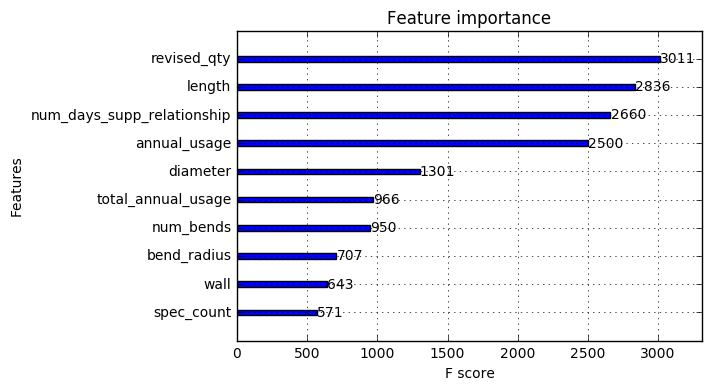

In [17]:
xgb_fi = xgb.plot_importance(xgbr, max_num_features = 10)

## from AWS (GS RF FINAL)

Best score:  0.885644436664
Best params:  {'n_estimators': 150, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_depth': None}
Grid Search Random Forest R2 test:  0.900841214003
Grid Search Random Forest RMSLE test:  0.260026548862